<a href="https://colab.research.google.com/github/abahnasy/cifar-experiments/blob/master/CIFAR_10_VGG11_SGD_w_Momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from PIL import Image

import os
import sys
import time
import math

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [21]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [22]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [23]:
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=64, shuffle=False, num_workers=4)

In [24]:
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.avgPool1 = nn.AvgPool2d(kernel_size=1, stride=1)
        self.fc1 = nn.Linear(512, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out,2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out,2)
        out = F.relu(self.bn3(self.conv3(out)))
        out = F.relu(self.bn4(self.conv4(out)))
        out = F.max_pool2d(out,2)
        out = F.relu(self.bn5(self.conv5(out)))
        out = F.relu(self.bn6(self.conv6(out)))
        out = F.max_pool2d(out,2)
        out = F.relu(self.bn7(self.conv7(out)))
        out = F.relu(self.bn8(self.conv8(out)))
        out = F.max_pool2d(out,2)
        out = self.avgPool1(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [26]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [27]:
net = VGG11()
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)

In [28]:
# get only one training image and pass it to the network
# im = transforms.ToPILImage()(torch.squeeze(next(iter(trainloader))[0], 0))
# im

sample = next(iter(trainloader))
smoketest_image = sample[0]
smoketest_label = sample[1]
print(smoketest_label)
net.train()
smoketest_image = smoketest_image.to(device)
smoketest_label = smoketest_label.to(device)
optimizer.zero_grad()
output = net(smoketest_image)
loss = criterion(output, smoketest_label)
loss.backward()
optimizer.step()


net.eval()
with torch.no_grad():
    output = net(smoketest_image)
    loss = criterion(output, smoketest_label)
    print("test loss", loss.item())
    _, predicted = output.max(1) # get the predicted label
    print("Print predicted label", predicted)
 

tensor([0, 6, 2, 0, 2, 5, 3, 3, 6, 4, 3, 1, 9, 5, 9, 9, 7, 5, 9, 9, 2, 9, 5, 0,
        4, 8, 1, 3, 7, 6, 5, 9, 6, 6, 6, 8, 9, 3, 7, 6, 6, 8, 1, 9, 9, 2, 6, 7,
        2, 8, 2, 5, 8, 2, 8, 4, 1, 7, 6, 5, 5, 2, 0, 7])
test loss 2.2866482734680176
Print predicted label tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')


In [30]:
num_epochs = 20
train_running_loss= []
train_running_acc= []
test_running_loss=[]
test_running_acc=[]

In [31]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0.0
    running_corrects = 0.0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
#         total += targets.size(0)
#         correct += predicted.eq(targets).sum().item()
        running_corrects += torch.sum(predicted == targets.data)
    #plot train loss
    train_running_loss.append(train_loss/len(trainset))
    train_running_acc.append(running_corrects.float()/len(trainset))
#     print("loss ", train_loss)

In [32]:
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0.0
    running_corrects = 0.0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
#             correct += predicted.eq(targets).sum().item()
            running_corrects += torch.sum(predicted == targets.data)
        # plot test loss
#         test_loss_plot.append(test_loss/len(testset))
        test_running_loss.append(test_loss/len(testset))
        test_running_acc.append(running_corrects/len(testset))
#         print("test loss", test_loss)

In [33]:
for epoch in range(start_epoch, start_epoch+num_epochs):
    train(epoch)
    test(epoch)



Epoch: 0

Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Epoch: 11

Epoch: 12

Epoch: 13

Epoch: 14

Epoch: 15

Epoch: 16

Epoch: 17

Epoch: 18

Epoch: 19


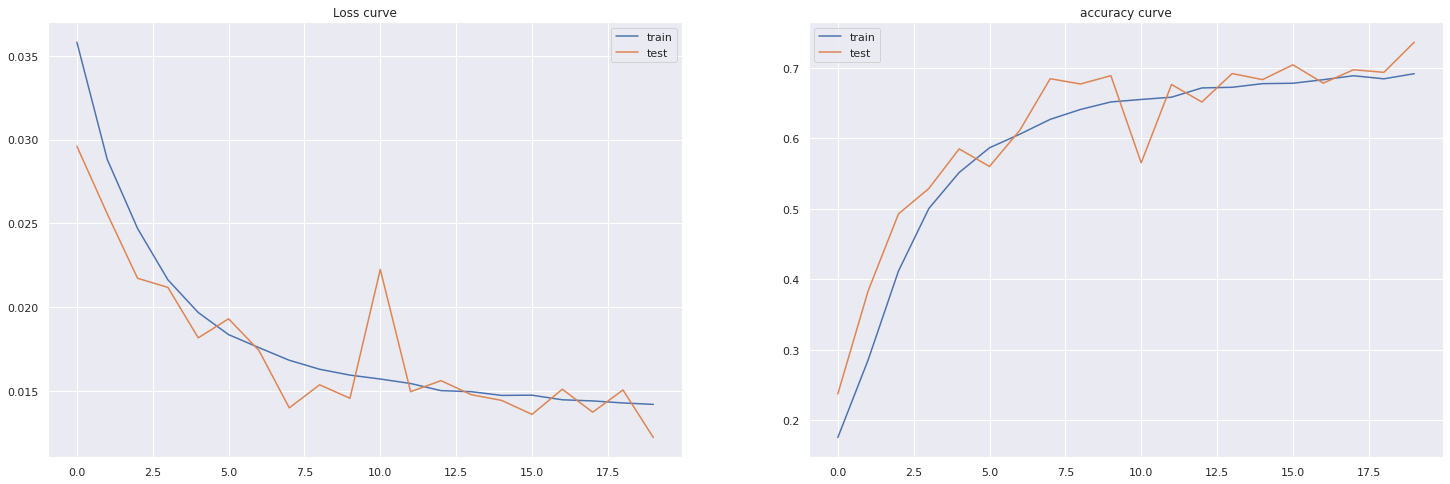

In [34]:
sns.set()
fig = plt.figure(1, figsize = (25,8))
ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_running_loss, label="train")
ax1.plot(range(num_epochs), test_running_loss, label="test")
ax1.set_title("Loss curve")
plt.legend()
ax2 = plt.subplot(1,2,2)

ax2.plot(range(num_epochs), train_running_acc, label="train")
ax2.plot(range(num_epochs), test_running_acc, label="test")
ax2.set_title("accuracy curve")
plt.legend()
plt.show()

# plt.plot(range(num_epochs), train_loss_plot, label="train")
# plt.plot(range(num_epochs), test_loss_plot, label="test")

In [35]:
correct_count, all_count = 0, 0
for images,labels in testloader:
    for i in range(len(labels)):
        img = images[i].view(1, 3, 32, 32).to(device)
        with torch.no_grad():
            logps = net(img)

        ps = torch.exp(logps)
        probab = list(ps.cpu().numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if(true_label == pred_label):
          correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.7365
